In [1]:
import os
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

## Loading the dataset

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
news = pd.read_json('../../../KEDatasets/KPTimes/KPTimes.train.jsonl', lines=True)

In [4]:
news.head(2)

,id,categories,date,title,abstract,keyword
0,ny0282969,"[us, politics]",2016-07-21,"For Donald Trump’s Big Speech, an Added Pressu...","CLEVELAND — Until Monday night, Donald J. Trum...",2016 Presidential Election;Donald Trump;Republ...
1,ny0225578,"[sports, hockey]",2010-10-16,"In Home Opener, Rangers Lose Gaborik and Drury...",There were silver linings to the Rangers ’ wil...,Hockey Ice;Toronto Maple Leafs;New York Ranger...


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [7]:
import time
from datetime import datetime

In [8]:
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

In [9]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T
from torch_geometric import utils

In [10]:
#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Importing FastText and loading a model for word vectors

In [11]:
import fasttext as ft

In [12]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

#### Most similar words to 'man' according to the model

In [13]:
ft_model.get_nearest_neighbors('man')

[(0.7125452756881714, 'woman'),
 (0.7092046141624451, 'stranger'),
 (0.7067620754241943, 'stupider'),
 (0.7021083235740662, 'thing'),
 (0.7005878686904907, 'darndest'),
 (0.6971448063850403, 'stupidest'),
 (0.692797839641571, 'beastly'),
 (0.6923372745513916, 'beast'),
 (0.6917076110839844, 'hater'),
 (0.6898659467697144, 'niggardly')]

This FastText model is trained only on a small subset of Wikipedia articles. It is much faster to load for daily experiments. The final version of the FastText model will be trained on the full Wikipedia dataset and fine-tuned for the KPTimes articles.

*Checking the KPTimes dataset for the duplicates.*

In [14]:
news['abstract'].duplicated().sum(), news.isnull().sum()

(21,
 id            0
 categories    0
 date          0
 title         0
 abstract      0
 keyword       0
 dtype: int64)

*What are the most popular categories for the news articles?*

In [15]:
news = news.drop_duplicates(subset='abstract').reset_index(drop=True)
news['keyword'] = news['keyword'].str.split(';')
news = news.explode('categories')
news['categories'].value_counts()

sports              61996
world               50828
business            49690
us                  41124
nyregion            40131
                    ...  
worldspecial3           1
nyregionspecial         1
newyorktoday            1
election-news           1
businessspecial6        1
Name: categories, Length: 92, dtype: int64

Now choosing only three most popular categories (sports, world and business), taking small number of articles from each of them and creating a new DataFrame.

In [16]:
np.random.seed(42)
topics = ['sports', 'world', 'business']
sports_id = news.loc[news['categories'] == 'sports'].index
world_id = news.loc[news['categories'] == 'world'].index
bus_id = news.loc[news['categories'] == 'business'].index
id1 = np.random.choice(sports_id, 20, replace=False).tolist()
id2 = np.random.choice(world_id, 20, replace=False).tolist()
id3 = np.random.choice(bus_id, 20, replace=False).tolist()
ids = id1 + id2 + id3
df = news[['abstract', 'categories', 'keyword']].loc[ids].copy()

In [17]:
df.shape

(108, 3)

60 articles in the new smaller DataFrame.

In [18]:
df = df.drop_duplicates('abstract').reset_index(drop=True)
df.shape

(60, 3)

List of prepositions to exclude from the text along with classical stopwords.

In [19]:
preps = [
  "a",
  "abaft",
  "aboard",
  "about",
  "above",
  "absent",
  "across",
  "afore",
  "after",
  "against",
  "along",
  "alongside",
  "amid",
  "amidst",
  "among",
  "amongst",
  "an",
  "anenst",
  "apropos",
  "apud",
  "around",
  "as",
  "aside",
  "astride",
  "at",
  "athwart",
  "atop",
  "barring",
  "before",
  "behind",
  "below",
  "beneath",
  "beside",
  "besides",
  "between",
  "beyond",
  "but",
  "by",
  "circa",
  "concerning",
  "despite",
  "down",
  "during",
  "except",
  "excluding",
  "failing",
  "following",
  "for",
  "forenenst",
  "from",
  "given",
  "in",
  "including",
  "inside",
  "into",
  "lest",
  "like",
  "mid",
  "midst",
  "minus",
  "modulo",
  "near",
  "next",
  "notwithstanding",
  "of",
  "off",
  "on",
  "onto",
  "opposite",
  "out",
  "outside",
  "over",
  "pace",
  "past",
  "per",
  "plus",
  "pro",
  "qua",
  "regarding",
  "round",
  "sans",
  "save",
  "since",
  "than",
  "the",
  "through",
  "throughout",
  "till",
  "times",
  "to",
  "toward",
  "towards",
  "under",
  "underneath",
  "unlike",
  "until",
  "unto",
  "up",
  "upon",
  "versus",
  "via",
  "vice",
  "with",
  "within",
  "without",
  "worth",
]

Cleaning the text from the stopwords and punctuation. Then extracting noun chunks with the **spacy** model to make keywords richer (e.g. taking *Donald Trump* together, instead of *Donald* and *Trump* separately).

In [20]:
######################## cleaning the text, splitting into chunks #########################################
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stops = ENGLISH_STOP_WORDS.union(set(preps))
signs = string.punctuation + '“' + '’' + '”'
punct_translator = str.maketrans('', '', signs)

def clean_chunks(chunks):
    new_chunks = []
    for pair in chunks:
        text = pair[0].translate(punct_translator)
        words = text.split()
        nchunk = ' '.join([w for w in words if w not in ENGLISH_STOP_WORDS])
        if len(text) > 2:
            new_chunks.append((nchunk, pair[1]))
    return new_chunks
            

def get_nchunks(x):
    nchunks = []
    #import pdb;pdb.set_trace()
    chunks = nlp(x).noun_chunks
    nchunks = [(c.text.lower(), (c.start_char, c.end_char)) 
               for c in chunks if c.text.lower() not in ENGLISH_STOP_WORDS]
    new_chunks = clean_chunks(nchunks)

    return new_chunks

The following functions create vocabulary (nodes) of the future graph.

In [21]:
#################################### creating vocabulary (nodes) ############################################################
def make_vocab(x):
    nchunks = x[3]
    #import pdb;pdb.set_trace()
    ss = x[0].lower()
    #print(ss)
    spans = list(list(zip(*nchunks))[1])
    keys = list(list(zip(*nchunks))[0])
    spans.extend([(len(ss),)])
    keys_ids = list(zip(keys, list(zip(*spans))[0]))
    non_chunks = [(ss[0:spans[0][0]], 0)]+[(ss[spans[i][-1]:spans[i+1][0]-1], spans[i][-1])
                                      for i in range(len(spans)-1)]
    non_chunks.extend(keys_ids)
    #print(non_chunks)
    words = list(zip(*sorted(non_chunks, key=lambda x: x[1])))[0]
    #print(words)
    vocab = []
    for w in words:
        if w not in keys:
            w = w.translate(punct_translator).lower().split()
            for i in w:
                if i not in ['', ' ', '  ', '   ']:
                    vocab.append(i)
        else: vocab.append(w)
    return vocab

Applying functions on the small dataset.

In [22]:
%time df['nchunks'] = df.loc[:, 'abstract'].apply(get_nchunks)

CPU times: user 4.51 s, sys: 0 ns, total: 4.51 s
Wall time: 4.51 s


In [23]:
%time df['vocab'] = df.apply(make_vocab, axis=1)

CPU times: user 59.2 ms, sys: 0 ns, total: 59.2 ms
Wall time: 58.4 ms


In [24]:
def clean_vocab(v):
    return [w for w in v if (w not in stops) and (len(w) > 3)]

df['vocab'] = df.loc[:, 'vocab'].apply(clean_vocab)

Example of vocabulary. Each word or noun chunk will be considered as a node.

In [25]:
print(df.iloc[0]['vocab'])

['matthew stafford', 'passed', '254 yards', 'touchdowns', 'detroit lions', 'held', 'late surge', 'host new orleans', 'defeat', 'saints', '3527', 'monday night', 'detroit', 'raced', '283 lead', 'drew brees', 'threw', 'touchdown', 'passes', 'lions', 'fumble', 'help', 'new orleans', 'pull', '2820', '10 minutes', 'left', 'detroits joique bell', 'scored', '1yard touchdown run', 'game', 'away', 'brees', 'passed', '341 yards', 'touchdowns', 'fourth quarterback', 'surpass', '60000 yards', 'career', 'eclipsing', '4000yard mark', '10th straight season', 'saints loss', 'guaranteed', 'consecutive losing seasons', 'time', 'sean payton', 'coach', '2006', 'golden tate', 'caught', 'touchdown', 'passes', 'detroit', 'broncos', 'stick', 'osweiler brock osweiler', 'remained', 'broncos', 'starting quarterback', 'pending medical tests', 'injured left shoulder', 'peyton manning', 'return', 'practice', 'wednesday', 'monday', 'broncos coach gary kubiak', 'said', 'changed', 'quarterback situation', 'denver', 'b

The following functions create edges between the words.

In [26]:
####################################### creating graph edges ##################################################
def get_edges(ordered_vocab, size=5):
    '''The words (nodes) are connected by an edge,
       if they appear together in a window of 5 words ('size' argument).
       The number can also be changed or chosen empirically.'''
    edges = OrderedDict({w: set() for w in ordered_vocab})
    size = len(ordered_vocab)
    for i in range(len(ordered_vocab)):
        start = i-size if i >= size else 0
        end = i+size if i+size < size else size-1
        nodes = {ordered_vocab[j] for j in range(start, end+1)}
        edges[ordered_vocab[i]].update(nodes)

    return edges

def word_mapping(edges_ordered_dict):
    '''Creating a mapping number --> word (node), 
       e.g. 0 --> matthew stafford,
            1 --> passed
       etc'''
    e = edges_ordered_dict
    return list(zip(e.keys(), range(len(e.keys()))))


def numeric_edges(row):
    '''Converting the edges into a format Pytorch Geometric accepts
       for creating a 'data' object, i.e.
       an iterable of size (2 x number_of_connections)'''
    mapping = dict(row['word_mapping'])
    edges = row['word_edges']
    num_map = {mapping[i]: [mapping[j] for j in edges[i]] for i in edges}
    groups = [list(zip([i]*len(num_map[i]), num_map[i])) for i in num_map]
    groups = list(chain.from_iterable(groups))
    return list(zip(*groups))

Creating nodes and edges for each article.

In [27]:
%time df['word_edges'] = df.loc[:, 'vocab'].apply(get_edges)

CPU times: user 376 ms, sys: 15.4 ms, total: 392 ms
Wall time: 391 ms


In [28]:
%time df['word_mapping'] = df.loc[:, 'word_edges'].apply(word_mapping)

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 11.3 ms


In [29]:
%time df['edges'] = df.apply(numeric_edges, axis=1)

CPU times: user 7.08 s, sys: 71.2 ms, total: 7.15 s
Wall time: 7.14 s


Example of the numeric edges: the first tuple represents outcoming node, the second - the destination nodes.

In [30]:
print(df.sort_values(by='word_mapping', key=lambda x:x.str.len()).iloc[0]['edges'])

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8), (0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8, 0, 4, 3, 5, 6, 7, 2, 1, 8)]


In [31]:
##################################### getting word vectors as node features ####################################
def get_token_vectors(word_map, chunks=True):
    '''Function gets a word (node) vector from FastText model
       mentioned above. These word vectors are going to be used
       as node features during the model training.'''
    vectors = OrderedDict()
    for word, i in word_map:
        if word not in vectors.keys():
            vectors[word] = ft_model.get_sentence_vector(word)
    array = np.stack(list(vectors.values()), axis=0)
    
    return array

In [32]:
%time df['node_vectors'] = df.loc[:, 'word_mapping'].apply(get_token_vectors)

CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 154 ms


In [33]:
#%store df

Stored 'df' (DataFrame)


Next, choosing the shortest article in order to understand better how simple GNNs work.

In [34]:
row = df.sort_values(by='vocab', key=lambda x: x.str.len()).iloc[0]
text = row['abstract']
keywords = row['keyword']
vocab = row['vocab']
edge_ids = row['edges']
node_vectors = row['node_vectors']
word_map = row['word_mapping']

Creating a Pytorch Geometric *data* object from the article

In [35]:
edge_index = torch.tensor(edge_ids, dtype=torch.long)
x = torch.tensor(node_vectors, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [36]:
data.num_edges

81

Loading Tensorboard extension

In [37]:
%load_ext tensorboard

### Learning unsupervised embeddings

The goal of this training is to see how unsupervised training will change the original word (nodes) embeddings. 

The model implementation is taken from https://github.com/hpi-sam/GNN-Lecture/blob/main/Stanford_Graph_Neural_Networks.ipynb

Initialising a *SummaryWriter* for Tensorboard

In [38]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [39]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

Before beginnning the training a graph can be interactively visualised with Bokeh

In [40]:
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,
                          NodesAndLinkedEdges, EdgesAndLinkedNodes)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

In [41]:
def show_bokeh_graph(G, param1, param2, param3, outfile=None):
    plot = Plot(plot_width=1500, plot_height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = ' '.join(vocab)

    node_hover_tool = HoverTool(
        tooltips=[(param1, "@{}".format(param1)),
                  (param2, "@{}".format(param2)),
                  (param3, "@{}".format(param3)),]
    )
    plot.add_tools(
        node_hover_tool, 
        BoxZoomTool(), 
        ResetTool()
    )

    graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))
    

    graph_renderer.node_renderer.glyph = Circle(
        size=15, 
        fill_color=Spectral4[0]
    )
    
    #graph_renderer.selection_policy = NodesAndLinkedEdges()
    #graph_renderer.inspection_policy = EdgesAndLinkedNodes()
    #graph_renderer.edge_renderer.glyph = MultiLine(
    #    line_color="edge_color", 
    #    line_alpha=0.8, 
    #    line_width=1
    #)
    plot.renderers.append(graph_renderer)
    if outfile:
        output_file(outfile)
    show(plot)


Converting an article graph to *networkx* and showing the node attributes.

In [42]:
G = utils.to_networkx(data, 
                      to_undirected=True)
attrs = {i[1]: {'word': i[0], 'degree': G.degree[i[1]], 'number': i[1]} for i in word_map}
nx.set_node_attributes(G, attrs)
attrs

{0: {'word': 'coach kyle flood', 'degree': 10, 'number': 0},
 1: {'word': 'said', 'degree': 10, 'number': 1},
 2: {'word': 'senior gary nova', 'degree': 10, 'number': 2},
 3: {'word': 'benched', 'degree': 10, 'number': 3},
 4: {'word': 'games', 'degree': 10, 'number': 4},
 5: {'word': 'season', 'degree': 10, 'number': 5},
 6: {'word': 'start', 'degree': 10, 'number': 6},
 7: {'word': 'quarterback', 'degree': 10, 'number': 7},
 8: {'word': 'rutgers', 'degree': 10, 'number': 8}}

In [43]:
show_bokeh_graph(G, 'word', 'degree', 'number')

### Labeling words in vocabulary as suitable to be a keyphrase (1) or not (0).

Original problem of keyphrases extraction from articles requires more complicated model architecture. For now, in order to improve understanding of GNNs, the task will be converted into the node classification. Each node in the graph is labeled as 1, if it is suitable to be a keyphrase and 0 otherwise. Also, to make it even easier for training, no nodes are masked for testing phase (no train-test split). 

In [44]:
'''Original text of the article chosen for training'''
text

'Coach Kyle Flood said the senior Gary Nova, benched for the last three games last season, would start at quarterback for Rutgers.'

In [45]:
print(word_map)

[('coach kyle flood', 0), ('said', 1), ('senior gary nova', 2), ('benched', 3), ('games', 4), ('season', 5), ('start', 6), ('quarterback', 7), ('rutgers', 8)]


Adding the labels to the *data*. The word-nodes chosen as keyphrases are: 'coach kyle flood', 'senior gary nova' and 'rutgers'.

In [46]:
labels  = torch.tensor([1, 0, 1, 0, 0, 0, 0, 0, 1],
                       dtype=torch.float)
data.y = labels

In [47]:
len(labels), len(word_map)

(9, 9)

Beginning the unsupervised training.

In [48]:
channels = 16
model = pyg_nn.GAE(Encoder(data.num_features, channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [49]:
def train(epoch, model, nodes, edges, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(nodes, edges)
    loss = model.recon_loss(z, edges)
    loss.backward()
    optimizer.step()
    
    #writer.add_scalar("loss", loss.item(), epoch)

#def test(pos_edge_index, neg_edge_index):
#    model.eval()
#    with torch.no_grad():
#        z = model.encode(x, train_pos_edge_index)
#    return model.test(z, pos_edge_index, neg_edge_index)

In [50]:
'''Training for 500 epochs'''
for epoch in range(1, 501):
    train(epoch, model, data.x, data.edge_index, optimizer)
    #auc, ap = test(data.x, data.test_neg_edge_index)
    #writer.add_scalar("AUC", auc, epoch)
    #writer.add_scalar("AP", ap, epoch)
    #if epoch % 10 == 0:
    #    print('Epoch: {:03d}'.format(epoch))

Visualising the embeddings obtained from the training

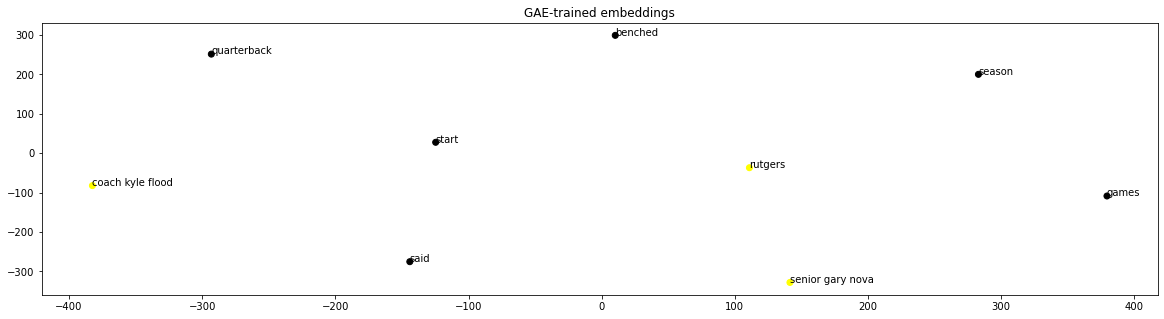

In [51]:
color_list = ['black', 'yellow']
model.eval()
z = model.encode(data.x, data.edge_index)
colors = [color_list[int(y.item())] for y in data.y]
xs, ys = zip(*TSNE(random_state=42).fit_transform(z.detach().numpy()))

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(xs, ys, color=colors)

for i, tupel in enumerate(word_map):
    ax.annotate(tupel[0], (xs[i], ys[i]))

plt.title('GAE-trained embeddings')
plt.show()

Are they different from the original embeddings from FastText?

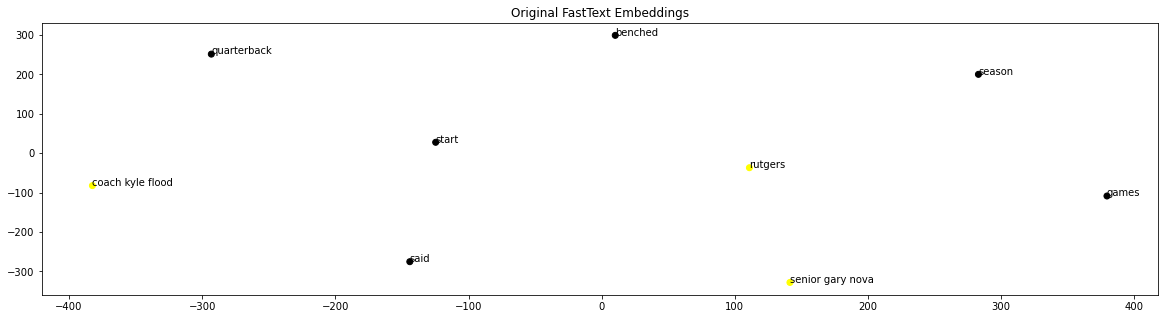

In [52]:
x_ax, y_ax = zip(*TSNE(random_state=42).fit_transform(x.detach().numpy()))

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(x_ax, y_ax, color=colors)

for i, tupel in enumerate(word_map):
    ax.annotate(tupel[0], (x_ax[i], y_ax[i]))
plt.title('Original FastText Embeddings')
plt.show()

Somehow the TSNE dimensionality reduction does not reflect any differences between the two embeddings. Could be that the training was not effective.

### Training a node classifier

Training a node classifier and visualising the weights and gradients with Tensorboard. The code is taken from the same link.

In [53]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, x, edge_index):
        #x, edge_index = data.x, data.edge_index#, data.batch
        #if data.num_node_features == 0:
        #    x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        #if self.task == 'graph':
        #    x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label.type(torch.LongTensor))

In [54]:
'''Adding a function to get accuracy'''
def get_accuracy(preds, targets):
    
    preds = preds.argmax(dim=1)
    ncorrects = preds.eq(targets).sum().item()
    return ncorrects / len(targets)

In [67]:
def train_node_clf(dataset, 
          #writer
         verbose=False):
    
    # build model
    model = GNNStack(max(dataset.x.shape[1], 1), 32, 2, 
                     task='node')
    
    opt = optim.Adam(model.parameters(), lr=0.01)
    #import pdb;pdb.set_trace()
    # train
    model.train()
    label = data.y
    losses = []
    accuracies = []
    for epoch in range(500):
        
        opt.zero_grad()
        embedding, pred = model(dataset.x, dataset.edge_index)
        #pred = pred[batch.train_mask]
        #label = label[batch.train_mask]
        writer.add_histogram('convs.0.weight', 
                             dict(model.named_parameters())['convs.0.weight'],
                            epoch)
        writer.add_histogram('convs.1.weight', 
                             dict(model.named_parameters())['convs.1.weight'],
                            epoch)
        writer.add_histogram('convs.2.weight', 
                             dict(model.named_parameters())['convs.2.weight'],
                            epoch)
        writer.add_histogram('post_mp.2.weight', 
                             dict(model.named_parameters())['post_mp.2.weight'],
                            epoch)
        if epoch != 0:
            writer.add_histogram('convs.2.weight Gradients', 
                                 dict(model.named_parameters())['convs.2.weight'].grad,
                                epoch)
            writer.add_histogram('post_mp.2.weight Gradients', 
                                 dict(model.named_parameters())['post_mp.2.weight'].grad,
                                epoch)
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()
        #total_loss += loss.item()
        acc = get_accuracy(pred, label)
        losses.append(loss.item())
        accuracies.append(acc)
        if verbose:
            print('Epoch', epoch)
            print('Loss', loss.item())

            print('Accuracy', acc)
            print('#########################################################')
        


    return model, losses, accuracies


Training the model for 500 epochs.

In [68]:
model, losses, accs = train_node_clf(data)

Visualising the losses and accuracies.

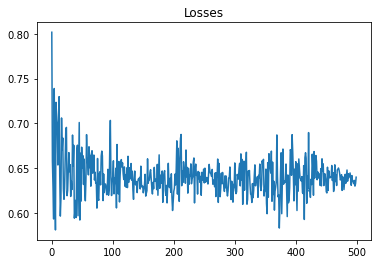

In [69]:
plt.plot(range(500), losses)
plt.title('Losses');

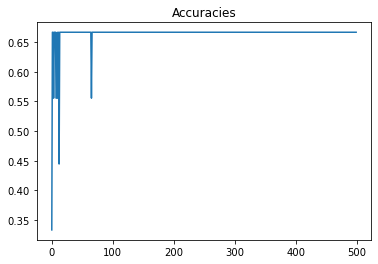

In [70]:
plt.plot(range(500), accs)
plt.title('Accuracies');

In [71]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 27171), started 0:51:18 ago. (Use '!kill 27171' to kill it.)

None of the plots reflects an adequate training. The reason is most likely unchanging gradients.

In [73]:
model.eval()
with torch.no_grad():
    embed, preds = model(data.x, data.edge_index)

Again, checking if the node embeddings have changed.

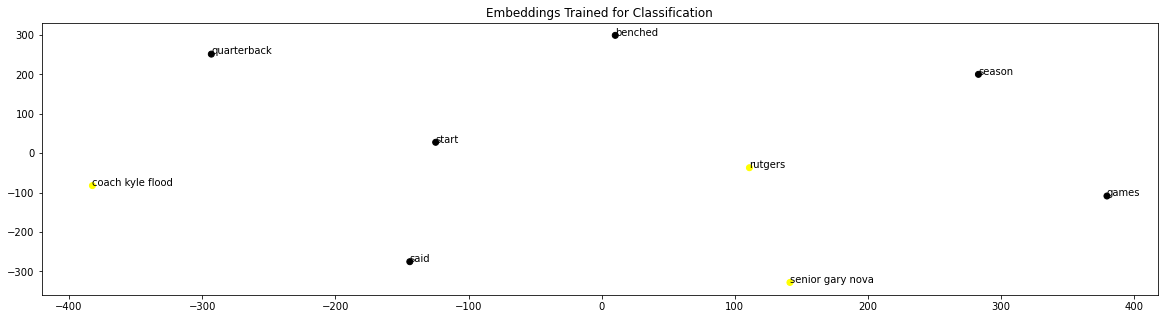

In [74]:
x_emb, y_emb = zip(*TSNE(random_state=42).fit_transform(embed.detach().numpy()))

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(x_emb, y_emb, color=colors)

for i, tupel in enumerate(word_map):
    ax.annotate(tupel[0], (x_emb[i], y_emb[i]))
plt.title('Embeddings Trained for Classification')
plt.show()

Comparing model predictions (above) with the true labels (below).

In [75]:
preds.argmax(dim=1), data.y

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 1.]))

### Training GAT classifier

Now training a Graph Attention Network for exactly the same graph (article). The code for the layers and models is taken from here: https://github.com/Diego999/pyGAT

In [76]:
class GraphAttentionLayer(nn.Module):
    
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W) # h.shape: (N, in_features), Wh.shape: (N, out_features)
        a_input = self._prepare_attentional_mechanism_input(Wh)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        N = Wh.size()[0] # number of nodes

        # Below, two matrices are created that contain embeddings in their rows in different orders.
        # (e stands for embedding)
        # These are the rows of the first matrix (Wh_repeated_in_chunks): 
        # e1, e1, ..., e1,            e2, e2, ..., e2,            ..., eN, eN, ..., eN
        # '-------------' -> N times  '-------------' -> N times       '-------------' -> N times
        # 
        # These are the rows of the second matrix (Wh_repeated_alternating): 
        # e1, e2, ..., eN, e1, e2, ..., eN, ..., e1, e2, ..., eN 
        # '----------------------------------------------------' -> N times
        # 
        
        Wh_repeated_in_chunks = Wh.repeat_interleave(N, dim=0)
        Wh_repeated_alternating = Wh.repeat(N, 1)
        # Wh_repeated_in_chunks.shape == Wh_repeated_alternating.shape == (N * N, out_features)

        # The all_combination_matrix, created below, will look like this (|| denotes concatenation):
        # e1 || e1
        # e1 || e2
        # e1 || e3
        # ...
        # e1 || eN
        # e2 || e1
        # e2 || e2
        # e2 || e3
        # ...
        # e2 || eN
        # ...
        # eN || e1
        # eN || e2
        # eN || e3
        # ...
        # eN || eN

        all_combinations_matrix = torch.cat([Wh_repeated_in_chunks, Wh_repeated_alternating], dim=1)
        # all_combinations_matrix.shape == (N * N, 2 * out_features)

        return all_combinations_matrix.view(N, N, 2 * self.out_features)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


In [77]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, 
                                               nhid, 
                                               dropout=dropout, 
                                               alpha=alpha, 
                                               concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, 
                                           dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        #import pdb;pdb.set_trace()
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)

In [78]:
# Model and optimizer
modelGAT = GAT(
    nfeat=data.num_node_features, 
    nhid=32, 
    nclass=2, 
    dropout=0.5, 
    nheads=2, 
    alpha=0.3
)
optimizerGAT = optim.Adam(
    modelGAT.parameters(), 
    lr=2e-4, 
    #weight_decay=args.weight_decay
)

In [84]:
def trainGAT(x, adj, label, nepochs, model, opt, verbose=False):
    
    model.train()
    losses = []
    accuracies = []
    
    for epoch in range(nepochs):
        
        #import pdb;pdb.set_trace()
        opt.zero_grad()
        preds = model(x, adj)
        writer.add_histogram('attention_0.W', 
                             dict(model.named_parameters())['attention_0.W'],
                            epoch)
        writer.add_histogram('attention_0.a', 
                             dict(model.named_parameters())['attention_0.a'],
                            epoch)
        writer.add_histogram('attention_1.W', 
                             dict(model.named_parameters())['attention_1.W'],
                            epoch)
        writer.add_histogram('attention_1.a', 
                             dict(model.named_parameters())['attention_1.a'],
                            epoch)
        writer.add_histogram('out_att.W', 
                             dict(model.named_parameters())['out_att.W'].grad,
                            epoch)
        writer.add_histogram('out_att.a', 
                             dict(model.named_parameters())['out_att.a'].grad,
                            epoch)
        
        loss = F.nll_loss(preds, label.type(torch.LongTensor))
        loss.backward()
        opt.step()

        acc = get_accuracy(preds, label)
        losses.append(loss.item())
        accuracies.append(acc)
        if verbose:
            print('Epoch', epoch)
            print('Loss', loss.item())

            print('Accuracy', acc)
            print('#########################################################')
        
        # * batch.num_graphs
        #total_loss /= len(loader.dataset)
        #writer.add_scalar("loss", total_loss, epoch)

        #if epoch % 10 == 0:
        #    test_acc = test(test_loader, model)
        #    print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
        #        epoch, total_loss, test_acc))
            #writer.add_scalar("test accuracy", test_acc, epoch)

    return model, losses, accuracies


Getting adjacency matrix of the graph and passing it to the model along with the node features.

In [85]:
data_adj = torch.from_numpy(nx.adjacency_matrix(G).toarray())
gat, gat_loss, gat_acc = trainGAT(data.x, data_adj, data.y,
                                  100, modelGAT, optimizerGAT)

Creating the figures for losses, accuracies, gradients and attention weights.

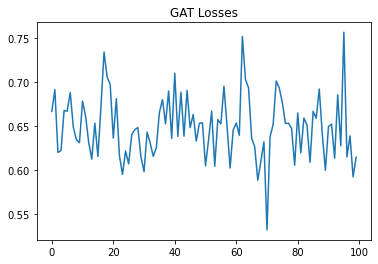

In [86]:
plt.plot(range(100), gat_loss)
plt.title('GAT Losses');

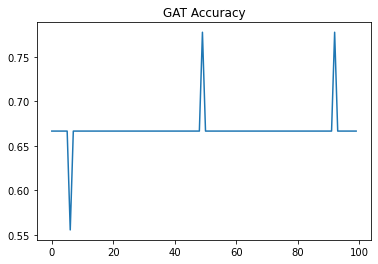

In [87]:
plt.plot(range(100), gat_acc)
plt.title('GAT Accuracy');

Comparing predictions with the true labels.

In [88]:
modelGAT.eval()
with torch.no_grad():
    print(modelGAT(data.x, data_adj).argmax(dim=1))
    print(data.y)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1.])


In [89]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 27171), started 1:10:17 ago. (Use '!kill 27171' to kill it.)

Again, the problem could be unchanging gradients. (Could it also be that the graph is too small (9 nodes only)? Although the notebook was also executed with the article of >30 nodes, the training was just as sad.)